## Simulation Example of Subj0024: Connectome-based simulation and virtually-aged simulation

The current notebook explores the resting-state simulation for a target subject of the 1000BRAINS dataset (Caspers et al., 2014). Functional data are simulated by means of a brain network model [(Sanz-Leon et al. 2013)](https://www.frontiersin.org/articles/10.3389/fninf.2013.00010/full), which is an ensemble of neural mass models linked via the weights of the structural connectivity (SC) matrix.  

We are going to provide details on the following topics:
1. The brain network model and the neural mass model by [Montbrio, Pazo and Roxin (MPR)(2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021028)
2. How to upload the SC connectivity matrices
3. The simulation with the original connectome and the simulation with the virtually aged-connectomes via TVB software
4. Output comparison between connectome-based simulation and virtually-aged simulation in terms of Bold data and Functional connectivity details
5. Introduction to the parameter sweep

## Creating a Brain-network Model

A brain-network model (BNM) is a graph-model whose nodes are the neural masses and whose edges are the SC weights. A neural mass represents the average activity (mean-field) of a neuronal population and its dynamic is described by a neural mass model. To understand how the BNM simualtions are obtained, we first delve into the mass dynamics as shown in [(Montbrio et al. 2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021028), which is at the core of our simulations.

### The neural mass model

The  Montrbio, Pazo, Roxin (MPR) neural mass model is a mean-field of an ensemble of infinite QIF neurons at the thermodynamic limit. Its phase-space is described by two state variables (the firing rate $r$ and the membrane potential $V$) according to the following differential equations: 

$$
\dot{r} = \frac{\Delta}{\pi} + 2rv
$$

$$
\dot{v} = v^2 + \bar{\eta} + Jr + I(t) - \pi^2 r^2
$$

The parameters for each mass ($\Delta$,$J$,$\bar{\eta}$) are tuned such that we can ensure a bistable dynamics. Given its three attractors (a stable fixed point, unstable fixed point and a limit cycle), the dynamics of the model can oscillate between the stable fixed point and the orbit of the limit cycle. The stable fixed point can be referred to as the down state (since the firing rate is closer to 0) and the limit cycle can be referred to as the up state (since the firing rate is closer to 1). To get a feeling about the phase space, check out the interactive phase space and how the noise can drive transtion between up and down states.

In this notebook, parameters ($\Delta$,$J$,$\bar{\eta}$) are hard coded in the notebook. According to [Rabuffo et al. 2021](https://www.eneuro.org/content/8/5/ENEURO.0283-21.2021), they are set as follows:
1. $J = 14.5$
2. $\Delta = 0.7$
3. $\eta = -4.6$
4. $\tau = 1$.

We invite the user to read in details [(Montbrio et al. 2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021028) to know more about $\tau$ parameter, which is set to 1 in this notebook.

### Brain network model

The brain network model is simply obtained by inserting the firing rate coming from other regions as input to each specific region. Given the MPR neural mass model 

$$
\dot{r_i} = \frac{\Delta}{\pi} + 2r_iv_i
$$

$$
\dot{v_i} = v_i^2 + \bar{\eta} + Jr_i + G\sum_{ij}w_{ij}r_{j}(t-\tau) + \xi_i(t) - \pi^2 r_i^2,
$$

we set the input $I(t)$ of the region $i$ as the sum of the firing rate $r_j$ coming from the regions $j$, mediated by SC weights $w_{ij}$ and the global modulation $G$. By definition, $G$ represents the overall impact of SC in determining the brain dynamics with TVB. Additionally, the noise $\xi_i$ and its variance $\sigma^2$ are pivotal to allow each region to autonomously oscillate between its own up and down states. The parameters $G$ and $\sigma^2$ are free parameters and they have to be tuned according to an optimization strategy.

The objectives of the notebook:
1. How to upload $SC$ $w_{ij}$
2. BNM-Simulation via TVB
3. The impact of $G$ in resting-state simulations

## Import packages

Import the most useful packages for this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from src import data,analysis,simulation
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
LOG = get_logger('demo')
import scipy.stats
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import warnings
warnings.filterwarnings("ignore")

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


## Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external` and the simulated dataset is located in the folder `$MYPATH/aging_virtual_brain/data/interim`. First, verify that the dataset is present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

## Upload SC matrices

We first define the list of subjects that we are interested to process. In this notebook, we focus only on
subj-0024. The constant $magic$ $number$ is the maximum SC edge of the entire 1000BD cohort.

In [2]:
P_LIST       = ['sub-0024']
magic_number = 124538.470647693

mysubj_idx   = 0
mysubj       = P_LIST[mysubj_idx]

The next codeblock uploads the 1000BRAINS dataset, the list of regions and the list of metadata of each subject. Please pay attention that the code uploads both the list of subjs of the folder and the list of all 1000BRAINS subjects of the study (available in csv). Do refer to the variable subjs and the sorted output based on the available data in the folder.

If you have downloaded the data correctly (see ***Data Alert*** block), the codeblock should not give any error message

In [3]:
separator  = ''
jul        = data.Julich() 
parce_list = jul.parcellation_100()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs      = jul.list_subjects()

SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]

The actual upload is performed with the function `load_subject_sc_100` as follows. $N_{Half}$ defines a constant which represents half of the number of regions (50 in this case)

In [4]:
_,weights     = jul.load_subject_sc_100(mysubj)
NHALF         = int(weights.shape[0]/2)

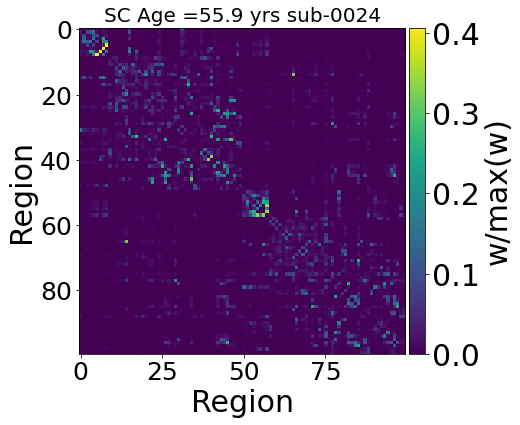

In [5]:
font_size = 20
f,ax = plt.subplots()

image=ax.imshow(weights/magic_number)
ax.set_ylabel("Region",fontsize=font_size+10)
ax.set_xlabel("Region",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)

separator = ''
str_title = separator.join(["SC Age =",f"{subj_age[SUBJ_TARG]}",' yrs ',mysubj])
plt.title(str_title,fontsize=font_size)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("w/max(w)",fontsize=font_size+10)
cbar.ax.tick_params(labelsize=font_size+10)

## Simulation wrapper and parameters

In order to simulate the functional data, we initiliaze a simulator object of the BNM via the function `run_alpha` by passing the label of our target subject, the definition of the MPR neuronal mass model, the simulation time interval $dt$, the noise variance $\sigma^2$, the value of global coupling $G$ and the simulation length. 

#### Definition of the parameters

In [6]:
dt           = 0.01

nsigma       = 0.03
seed         = 42
sim_len      = 30e3 ## 5mins simulation 


G_TARG       = 2.45
G_ALPHA      = 2.6
nsigma_alpha = 0.03

alpha        = 0.5
alpha_zero   = 0.0

## Definition of the simulator object and wrapper

Inside `run_alpha`, we upload the connectivity matrix via `load_subject_sc_100`and we normalize it via the magic number. 

Inside `run_alpha`, we also use the runner wrapper `simulation.run_nbMPR_backend` to start the actual simulation by passing the simulator object and the simulation length, which has been set up to 5 minutes.

We can derive the BOLD data by applying the Windkessel model to the the simulated data with the function `simulation.tavg_to_bold`.

By passing the parameter $\alpha$ / `alpha`, we can also virtually age the connectome of the target subject, which will then be used as a connectivity matrix of the simulator object. If we set $\alpha=0$, the virtual aging is not applied, i.e. a connectome-based simulation.

The formula for virtually aging is:
    $$SC_{aged} = SC_{0} - \alpha * SC_{0} * M_{inter},$$
as discussed in details in the notebook `$MYPATH/aging_virtual_brain/notebooks/vab_github_sc_investigation.ipynb`

In [7]:
def run_alpha(G,nsigma,mysubj,sim_len,out_path,alpha):
    
    t0 = time.time()
    
    jul                                       = data.Julich()
    subjs                                     = jul.list_subjects()
    subj_age,gender,education,subj_ID,_,_,_,_ = jul.metadata()
    magic_number = 124538.470647693

    SUBJ_TARG     = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
    myage         = subj_age[SUBJ_TARG]

    _, weights    = jul.load_subject_sc_100(mysubj)
    NHALF         = int(weights.shape[0]/2)

    mask_inter                              = np.zeros(weights.shape)
    mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
    mask_inter[NHALF:NHALF*2,0:NHALF]       = 1

    weights_orig                            = weights/magic_number
    weights_symm                            = weights_orig - alpha*weights_orig*mask_inter
      
    conn               = connectivity.Connectivity(
        weights=weights_symm,
        region_labels=np.array(np.zeros(np.shape(weights_symm)[0]),dtype='<U128'),
        tract_lengths=np.zeros(np.shape(weights_symm)),
        areas =np.zeros(np.shape(weights_symm)[0]),
        speed=np.array(np.Inf,dtype=np.float),
        centres = np.zeros(np.shape(weights_symm)[0])) # default 76 regions 

    mpr=models.MontbrioPazoRoxin(
            eta   = np.r_[-4.6],
            J     = np.r_[14.5],
            Delta = np.r_[0.7],
            tau   = np.r_[1],
        )

    sim = simulator.Simulator(model=mpr,
    connectivity=conn,
        coupling=coupling.Scaling(
          a=np.r_[G]
        ),
    conduction_speed=np.Inf,
        integrator=integrators.HeunStochastic(
          dt=dt,
          noise=noise.Additive(
              nsig=np.r_[nsigma, nsigma*2],
              noise_seed=seed
          )
    ),
    monitors=[
          monitors.TemporalAverage(period=0.1),
        ]
    )

    sim.configure()

    (TemporalAverage_time, TemporalAverage_data), = simulation.run_nbMPR_backend(sim, simulation_length=sim_len)
    TemporalAverage_time *= 10 # rescale time
    Bold_time, Bold_data = simulation.tavg_to_bold(TemporalAverage_time, TemporalAverage_data, tavg_period=1., connectivity=sim.connectivity, svar=0, decimate=2000)


    np.savez(out_path, Bold_data = Bold_data, Bold_time = Bold_time,TemporalAverage_data = TemporalAverage_data, TemporalAverage_time = TemporalAverage_time)

    CPU_TIME = time.time() - t0
    print(['CPU time-->',CPU_TIME])
    
    

Functions to collect the firing-rate and the membrane potential of the BNM as well as the BOLD time series.

In [8]:
def collect_data(G,nsigma,mysubj,alpha):
    
    str_save      = separator.join(['temporary_result/showcase/julich_data',
                             '_pat',f"{mysubj}",'_G',f"{G}",'_noise',f"{nsigma}",'_alpha',f"{alpha}",'_vageing.npz'])
    out_path      = os.path.join(jul.data_root,str_save)
    
    output_data   = np.load(out_path)
                                     
    return output_data 

In [9]:
def collect_bold(G,nsigma,mysubj,alpha):
    
    output_data     = collect_data(G,nsigma,mysubj,alpha)
    
    bold            = output_data['Bold_data'][:,0,:,0]
    time_bold       = output_data['Bold_time']
    
    return bold,time_bold

## Simulation using the same G for both the empirical connectome and the virtually-aged connectome

We run the actual simulation by calling the `run_alpha` with the specified parameters.

Connectome-based simulation ($\alpha=0$) with $G=2.45$

In [10]:
str_save      = separator.join(['temporary_result/showcase/julich_data',
                     '_pat',f"{mysubj}",'_G',f"{G_TARG}",'_noise',f"{nsigma}",'_alpha',f"{alpha_zero}",'_vageing.npz'])
out_path      = os.path.join(jul.data_root,str_save)

run_alpha(G_TARG,nsigma,mysubj,sim_len,out_path,alpha_zero)

['CPU time-->', 149.8245837688446]


Virtual-aging simulation ($\alpha=0.5$) with $G=2.45$

In [11]:
str_save      = separator.join(['temporary_result/showcase/julich_data',
                     '_pat',f"{mysubj}",'_G',f"{G_TARG}",'_noise',f"{nsigma}",'_alpha',f"{alpha}",'_vageing.npz'])
out_path      = os.path.join(jul.data_root,str_save)

run_alpha(G_TARG,nsigma,mysubj,sim_len,out_path,alpha)      

['CPU time-->', 146.92367815971375]


## Simulation using an increasing G for the virtually-aged connectome

In order to introduce the main result of the virtual aging brain, we test what happens if we simulate data with the same virtually age-connectome ($\alpha=0.5$) but a higher $G$.

Virtual-aging simulation ($\alpha=0.5$) with $G=2.6$

In [12]:
str_save      = separator.join(['temporary_result/showcase/julich_data',
                     '_pat',f"{mysubj}",'_G',f"{G_ALPHA}",'_noise',f"{nsigma_alpha}",'_alpha',f"{alpha}",'_vageing.npz'])
out_path      = os.path.join(jul.data_root,str_save)

run_alpha(G_ALPHA,nsigma_alpha,mysubj,sim_len,out_path,alpha)

['CPU time-->', 146.37290120124817]


## Simulation output: firing rate time series and phase-space for one node

We collect the firing-rate data and we plot all the time series in one single plot. We notice that the firing rate is bounded between zero and an oscillatory activity around 2. It is also characterized by transisitions between the down-state or zero and the up-state or the oscillatory activity around 2. We refer to this behavior as bistability.

In [13]:
output_data   = collect_data(G_TARG,nsigma,mysubj,alpha_zero)

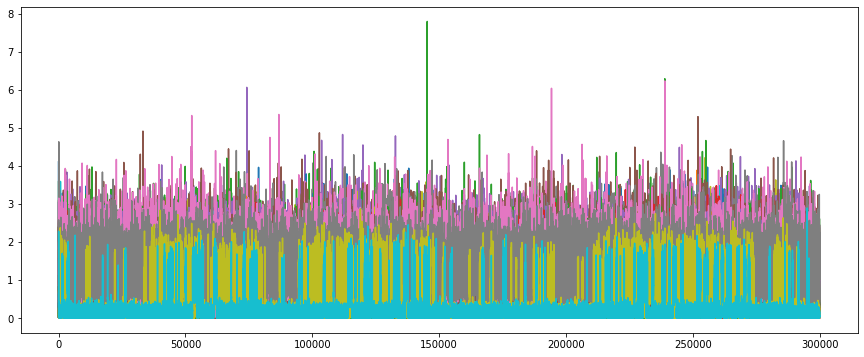

In [14]:
r = output_data['TemporalAverage_data'][:,0,:,0]
v = output_data['TemporalAverage_data'][:,1,:,0]

plt.plot(r);

We can confirm the presence of the oscillatory activity by looking at the phase space of one single node, which is obtained by plotting the firing rate on the x-axis and the membrane potential on the y-axis.

[Text(0, -3.0, ''),
 Text(0, -2.0, ''),
 Text(0, -1.0, ''),
 Text(0, 0.0, ''),
 Text(0, 1.0, '')]

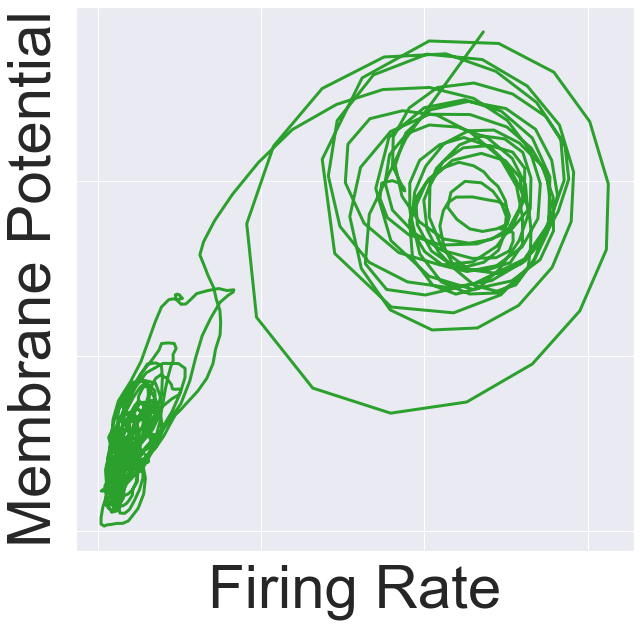

In [15]:
import seaborn as sns
import pandas as pd
import pylab
from scipy.signal import savgol_filter

font_size = 40

path_root   = os.path.dirname(os.getcwd()) 

from scipy.interpolate import make_interp_spline
from scipy.interpolate import CubicSpline

sns.set_theme(style="darkgrid")

palette = sns.color_palette("tab10")

r_vect = savgol_filter(r[10000:11000,43],15,3)
v_vect = savgol_filter(v[10000:11000,43],15,3)

f,ax = plt.subplots(figsize=(10,10))

loc_r = np.argsort(r_vect)

data_rv = pd.DataFrame(
        {'r':r_vect,
        'v':v_vect})

sns.lineplot(data=data_rv, x="r", y="v",sort=False,lw=3,color = palette[2])


palette  = sns.color_palette("husl", 8)

U,V=np.meshgrid(r_vect,v_vect)

ax.set_xlabel("Firing Rate",fontsize=font_size+20)
ax.set_ylabel("Membrane Potential",fontsize=font_size+20);


ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

## Simulated BOLD

We can assess the bistable in-silico transition behavior by showing a carpet plot of the BOLD data. It is easy to notice that the empirical connectome ($\alpha=0.0$,$G=2.45$) show a greater transition between states compared to virtually-aged connectome ($\alpha=0.5$,$G=2.45$). However, if we increase the coupling $G$, the transition behavior re-appears for the virtually aged-connectome ($\alpha=0.5$,$G=2.6$).

Connectome-based simulation ($\alpha=0$) with $G=2.45$

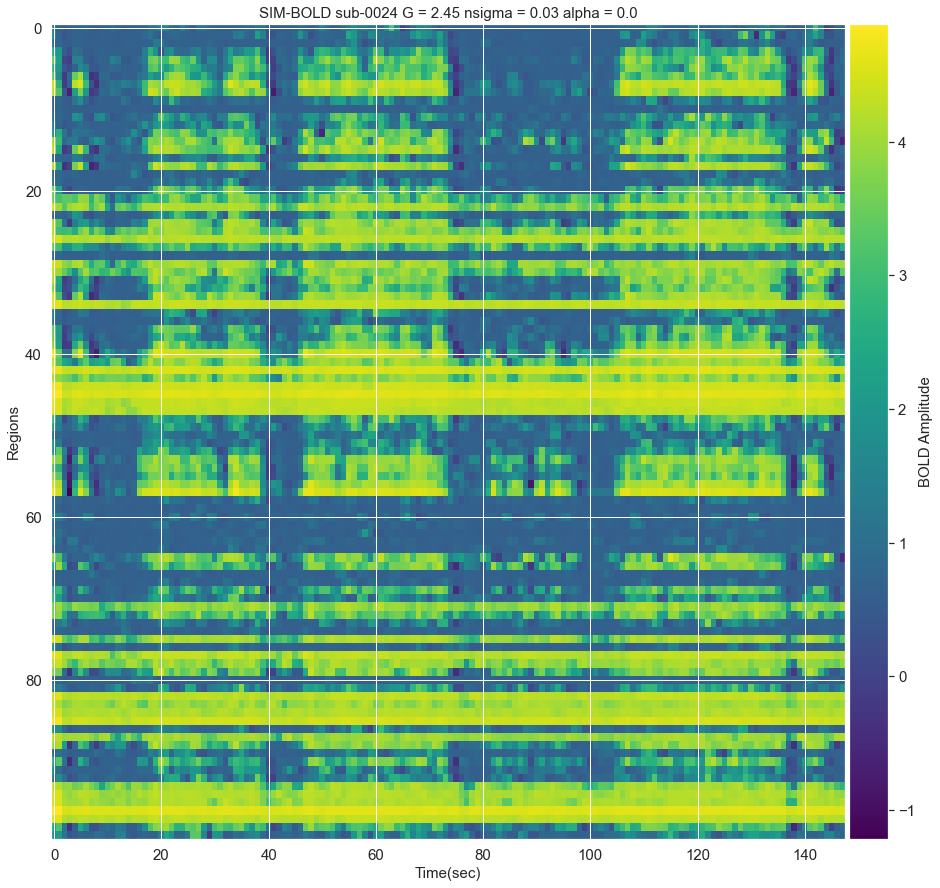

In [16]:
f,ax = plt.subplots(figsize=(15,15))
font_size = 15
bold,time_bold   = collect_bold(G_TARG,nsigma,mysubj,alpha_zero)
image = ax.imshow(bold[int(5e3/2000):,:].T,aspect='auto',cmap='viridis')

mytit = separator.join(['SIM-BOLD ',mysubj,' G = ', str(G_TARG), 
                        ' nsigma = ', str(nsigma), ' alpha = ',str(alpha_zero)])

ax.set_title(mytit,fontsize = font_size)
ax.tick_params(axis="x", labelsize=font_size)  
ax.tick_params(axis="y", labelsize=font_size)
ax.set_xlabel('Time(sec)', fontsize=font_size)
ax.set_ylabel('Regions', fontsize=font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("BOLD Amplitude",fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)


Virtual-aging simulation ($\alpha=0.5$) with $G=2.45$

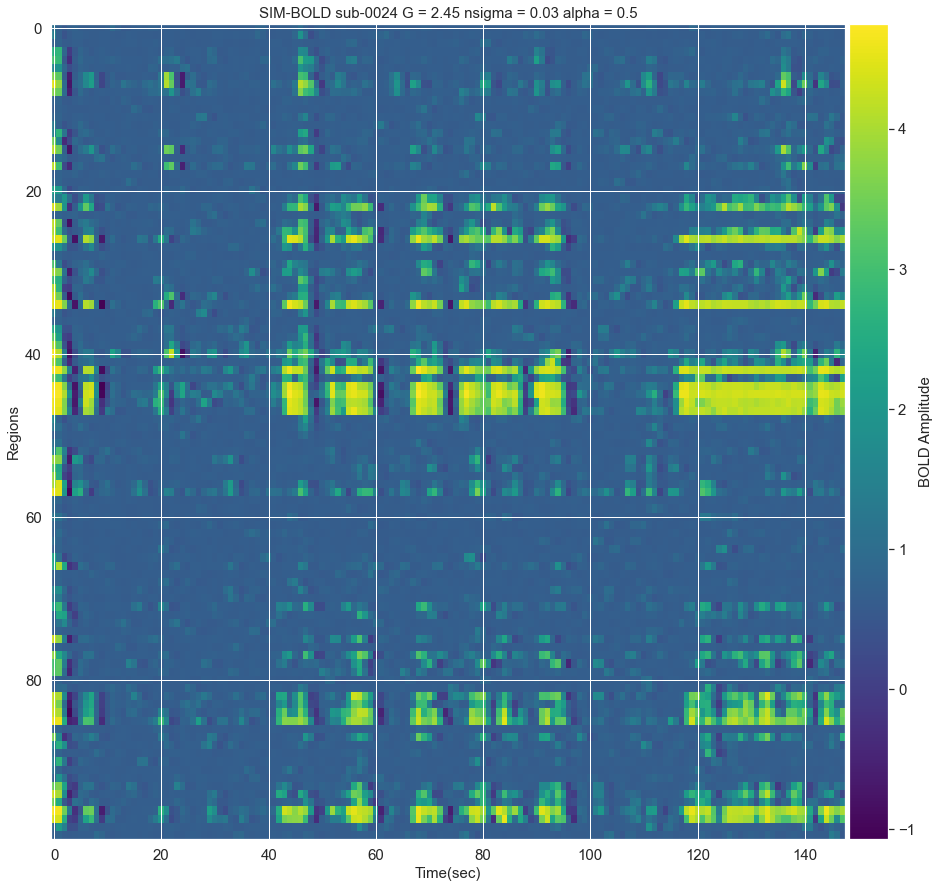

In [17]:
f,ax = plt.subplots(figsize=(15,15))
# image = ax.imshow(bold[:,vis_rsn].T)
font_size = 15
bold,time_bold   = collect_bold(G_TARG,nsigma,mysubj,alpha)
image = ax.imshow(bold[int(5e3/2000):,:].T,aspect='auto',cmap='viridis')

mytit = separator.join(['SIM-BOLD ',mysubj,' G = ', str(G_TARG), 
                        ' nsigma = ', str(nsigma), ' alpha = ',str(alpha)])

ax.set_title(mytit,fontsize = font_size)
ax.tick_params(axis="x", labelsize=font_size)  
ax.tick_params(axis="y", labelsize=font_size)
ax.set_xlabel('Time(sec)', fontsize=font_size)
ax.set_ylabel('Regions', fontsize=font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("BOLD Amplitude",fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)


Virtual-aging simulation ($\alpha=0.5$) with $G=2.6$

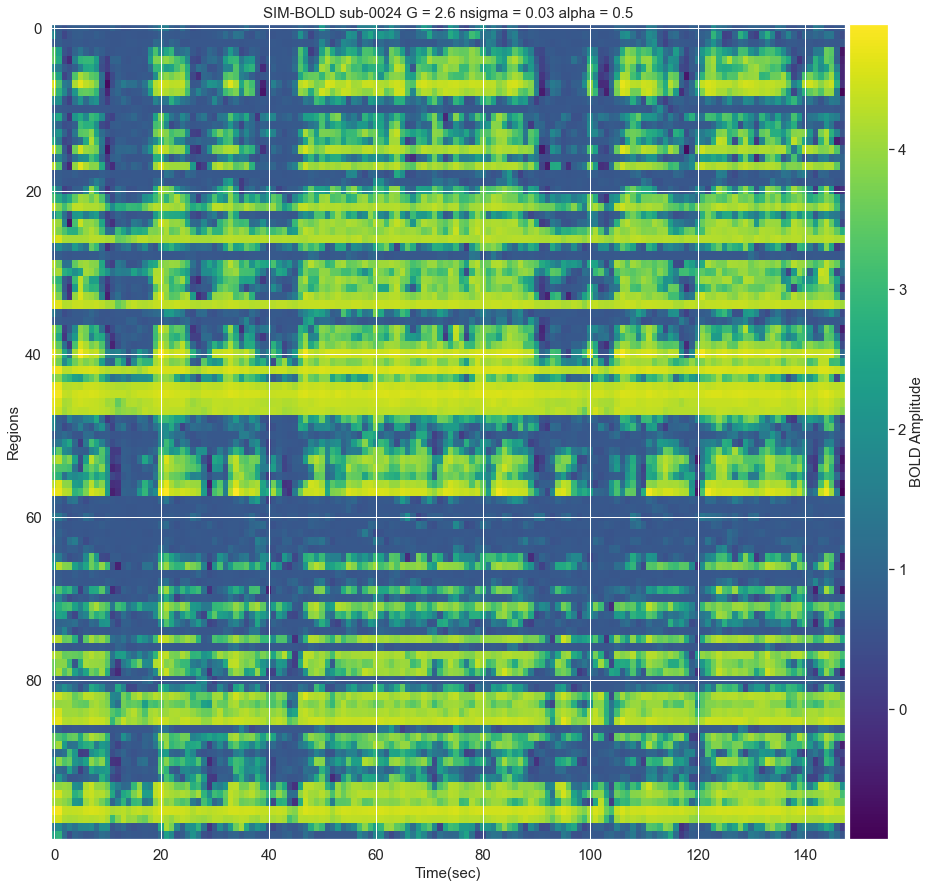

In [18]:
f,ax = plt.subplots(figsize=(15,15))
font_size = 15
bold_alpha,time_bold   = collect_bold(G_ALPHA,nsigma_alpha,mysubj,alpha)
image = ax.imshow(bold_alpha[int(5e3/2000):,:].T,aspect='auto',cmap='viridis')

mytit = separator.join(['SIM-BOLD ',mysubj,' G = ', str(G_ALPHA), 
                        ' nsigma = ', str(nsigma_alpha), ' alpha = ',str(alpha)])

ax.set_title(mytit,fontsize = font_size)
ax.tick_params(axis="x", labelsize=font_size)  
ax.tick_params(axis="y", labelsize=font_size)
ax.set_xlabel('Time(sec)', fontsize=font_size)
ax.set_ylabel('Regions', fontsize=font_size)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("BOLD Amplitude",fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)


## FCD

To check the bistability, we could also compute the functional connectivity dynamics. 

The FCD is a metric to assess the variability of the functional connectivity over time. It is represented as a $time \times time$ matrix and each entry represents the pearson correlation between a time sample and the next one as follows:

$$
FCD(t_i,t_j) = Pearson(FC(t_i),FC(t_j))
$$

where $FC(t_i)$ represents the Functional connectivity computed in a specific time window.

A bistable system will be characterized by a checkerboard pattern in the FCD matrix. Therefore, a compressed index of functional time-variability or bistability is the variance of the FCD $\sigma^2(FCD)$, which is the variance of the upper triangular matrix of $FCD$. Here below, we compare the FCDs for connectome-based simulation ($\alpha=0$) with $G=2.45$ and the virtually-aged simulation ($\alpha=0.5$) with same $G$. We also show what happens if we increase $G$ ($G=2.6$). 

Similarly to the carpet plot, the $\sigma^2(FCD)$ for the connectome-based simulation is higher than the virtually-aged simulation, unless we increase $G$ ($G=2.6$).

Connectome-based simulation ($\alpha=0$) with $G=2.45$

0.690827363662627
2.45
0.03
0.036619054763130404


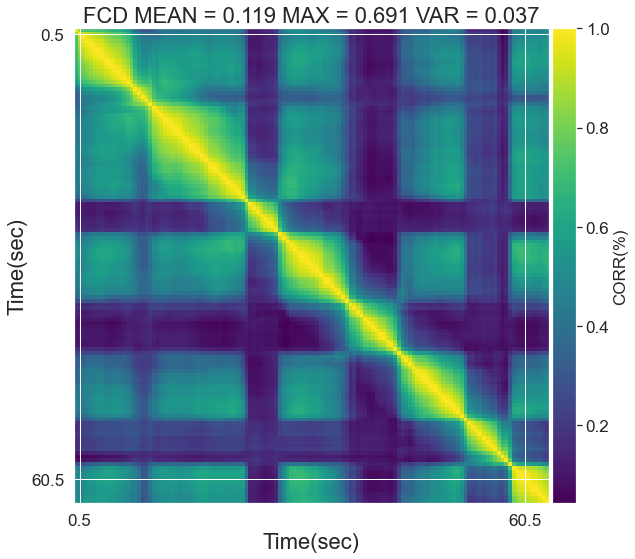

In [19]:
path_root  = os.path.dirname(os.getcwd())

# ALPHA1 = 0.8
# ALPHA2 = 0.2

PAT_IDX = 0
mysubj = P_LIST[PAT_IDX]
G_CHOS = 17
N_CHOS = 8
font_size = 12

win_FCD = 40e3


transient    = int(5e3/2000)

from mpl_toolkits.axes_grid1 import make_axes_locatable
bold,time_bold   = collect_bold(G_TARG,nsigma,mysubj,alpha_zero)
FCD, fc_stack, speed_fcd = analysis.compute_fcd(bold[transient:,:], win_len=int(win_FCD/2000), win_sp=1)
# FCD_plot = np.triu(FCD, k=int(win_FCD/2000)) + np.tril(FCD, k=-int(win_FCD/2000))
FCD_plot = FCD
print(np.max(np.triu(FCD_plot, k=int(win_FCD/2000))))
f,ax = plt.subplots(figsize=(9,9))
image = ax.imshow(FCD_plot,cmap='viridis')
ax.set_ylabel("Time(sec)",fontsize=font_size+10)
ax.set_xlabel("Time(sec)",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)


loc   = range(1,FCD.shape[0],120)
label = np.array(loc)*0.5
label = label.round(2)

plt.xticks(loc, label);
plt.yticks(loc, label);
mean_FCD = np.mean(np.triu(FCD_plot, k=int(win_FCD/2000)))
max_FCD = np.max(np.triu(FCD_plot, k=int(win_FCD/2000)))
var_FCD = np.var(np.triu(FCD_plot, k=int(win_FCD/2000)))
min_FCD = np.min(np.triu(FCD_plot, k=int(win_FCD/2000)))

separator = ''
str_title = separator.join(["FCD MEAN = ",f"{mean_FCD:.3f}"," MAX = ",f"{max_FCD:.3f}"," VAR = ",f"{var_FCD:.3f}"])
plt.title(str_title,fontsize=font_size+10)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("CORR(%)",fontsize=font_size+5)
cbar.ax.tick_params(labelsize=font_size+5)                 
        
print(G_TARG) 
print(nsigma)
print(var_FCD)

Virtual-aging simulation ($\alpha=0.5$) with $G=2.45$

0.4391706967823653
2.45
0.03
0.010009149693484118


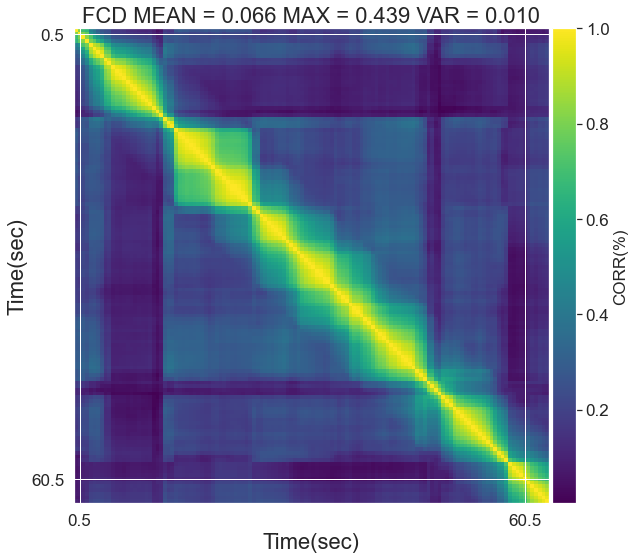

In [20]:
path_root  = os.path.dirname(os.getcwd())

# ALPHA1 = 0.8
# ALPHA2 = 0.2

PAT_IDX = 0
mysubj = P_LIST[PAT_IDX]
G_CHOS = 17
N_CHOS = 8
font_size = 12

win_FCD = 40e3

from mpl_toolkits.axes_grid1 import make_axes_locatable
bold,time_bold   = collect_bold(G_TARG,nsigma,mysubj,alpha)
FCD, fc_stack, speed_fcd = analysis.compute_fcd(bold[transient:,:], win_len=int(win_FCD/2000), win_sp=1)
# FCD_plot = np.triu(FCD, k=int(win_FCD/2000)) + np.tril(FCD, k=-int(win_FCD/2000))
FCD_plot = FCD
print(np.max(np.triu(FCD_plot, k=int(win_FCD/2000))))
f,ax = plt.subplots(figsize=(9,9))
image = ax.imshow(FCD_plot,cmap='viridis')
ax.set_ylabel("Time(sec)",fontsize=font_size+10)
ax.set_xlabel("Time(sec)",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)


loc   = range(1,FCD.shape[0],120)
label = np.array(loc)*0.5
label = label.round(2)

plt.xticks(loc, label);
plt.yticks(loc, label);
mean_FCD = np.mean(np.triu(FCD_plot, k=int(win_FCD/2000)))
max_FCD = np.max(np.triu(FCD_plot, k=int(win_FCD/2000)))
var_FCD = np.var(np.triu(FCD_plot, k=int(win_FCD/2000)))
min_FCD = np.min(np.triu(FCD_plot, k=int(win_FCD/2000)))

separator = ''
str_title = separator.join(["FCD MEAN = ",f"{mean_FCD:.3f}"," MAX = ",f"{max_FCD:.3f}"," VAR = ",f"{var_FCD:.3f}"])
plt.title(str_title,fontsize=font_size+10)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("CORR(%)",fontsize=font_size+5)
cbar.ax.tick_params(labelsize=font_size+5)                 
        
print(G_TARG) 
print(nsigma)
print(var_FCD)

Virtual-aging simulation ($\alpha=0.5$) with $G=2.6$

0.6676576464171076
2.45
0.03
0.04083015372821766


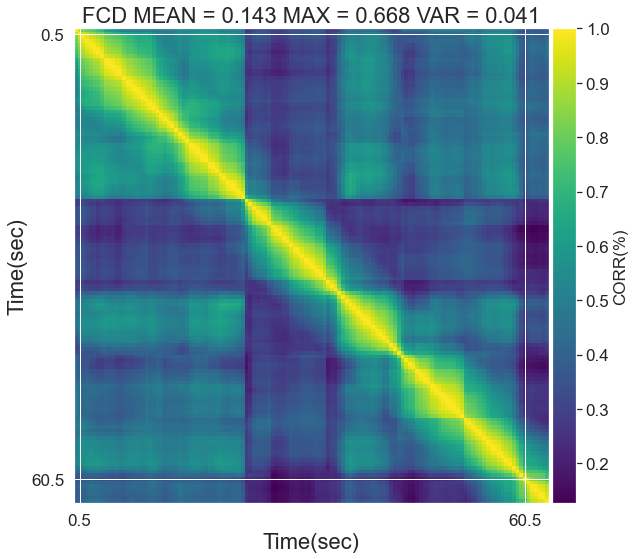

In [21]:
path_root  = os.path.dirname(os.getcwd())

# ALPHA1 = 0.8
# ALPHA2 = 0.2

PAT_IDX = 0
mysubj = P_LIST[PAT_IDX]
G_CHOS = 17
N_CHOS = 8
font_size = 12

win_FCD = 40e3

from mpl_toolkits.axes_grid1 import make_axes_locatable
bold,time_bold   = collect_bold(G_ALPHA,nsigma_alpha,mysubj,alpha)
FCD, fc_stack, speed_fcd = analysis.compute_fcd(bold[transient:,:], win_len=int(win_FCD/2000), win_sp=1)
# FCD_plot = np.triu(FCD, k=int(win_FCD/2000)) + np.tril(FCD, k=-int(win_FCD/2000))
FCD_plot = FCD
print(np.max(np.triu(FCD_plot, k=int(win_FCD/2000))))
f,ax = plt.subplots(figsize=(9,9))
image = ax.imshow(FCD_plot,cmap='viridis')
ax.set_ylabel("Time(sec)",fontsize=font_size+10)
ax.set_xlabel("Time(sec)",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)


loc   = range(1,FCD.shape[0],120)
label = np.array(loc)*0.5
label = label.round(2)

plt.xticks(loc, label);
plt.yticks(loc, label);
mean_FCD = np.mean(np.triu(FCD_plot, k=int(win_FCD/2000)))
max_FCD = np.max(np.triu(FCD_plot, k=int(win_FCD/2000)))
var_FCD = np.var(np.triu(FCD_plot, k=int(win_FCD/2000)))
min_FCD = np.min(np.triu(FCD_plot, k=int(win_FCD/2000)))

separator = ''
str_title = separator.join(["FCD MEAN = ",f"{mean_FCD:.3f}"," MAX = ",f"{max_FCD:.3f}"," VAR = ",f"{var_FCD:.3f}"])
plt.title(str_title,fontsize=font_size+10)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("CORR(%)",fontsize=font_size+5)
cbar.ax.tick_params(labelsize=font_size+5)                 
        
print(G_TARG) 
print(nsigma)
print(var_FCD)

## Perform the remaining sweep on the HPC facility

The example above shows the simulation for one single subject and a single pair of $(G,\sigma^2)$ parameters. The tuning parameters of the brain-network model, which are the noise variance and the global coupling G, are normally selected according an optimization strategy. In the VAB pipeline, we sweep the parameters in the range $G = [1.5 - 3.2]$ and the range $\sigma^2 = [0.01-0.05]$ to maximise the variance of the FCD $\sigma^2(FCD)$, which is the variance of the upper triangular matrix of $FCD$.  

By performing performs a parameter sweep to maximise $\sigma^2(FCD)$, we obtain a landscape for the brain fluidity or dynamical flexibility or a paramter map of each connectome. Specifically, the parameter sweep is repeated:
1. For the 649 connectomes of 1000BRAINS dataset
2. For the 50 youngest subjects whose connectomes were virtually aged in the range $\alpha=[0-1]$

To understand why we want to maximise $\sigma^2(FCD)$ in order to tune $G$ and the noise variance $\sigma^2$ , we invite you to read our article,  [Rabuffo et al. 2021](https://www.eneuro.org/content/8/5/ENEURO.0283-21.2021) for resting-state analysis or [Courtiol et al., 2020](https://www.jneurosci.org/content/40/29/5572) for epilepsy.

To produce the parameter map we need to run a simulation instance for each parametrization of the model. In this particular case it entails 315 independent simulations (see `$MYPATH/aging_virtual_brain/notebooks/vab_github_summary_data.ipynb`). Although the parameter sweep is conceptually simple, it requires an intensive computational effort to repeat this process for each subject. Such computation is beyond what is practical in the interactive environment of the Jupyterlab. Since the sweep is an "embarrassing parallel" problem, but it can make use of the high-performance computing (HPC) infrastructure and parallel computing .

In the VAB pipeline, we used [snakemake](https://snakemake.readthedocs.io/en/stable/) to compile the list of jobs necessary to perform either for the empirical connectomes cohort or the virtually aged-one. Once the snakemake diagram is defined, you can process your jobs on your cluster of choice via the follwoing command:

`snakemake -s snakes/run_vab_snakemake.snake --cluster "sbatch --time 48:00:00 -J vab_sb --ntasks-per-socket=4 --mem-per-cpu=32G --output ${results_dir}/${out_dir}/virtual_aging%j.log --error ${results_dir}/${err_dir}/virtual_aging%j.log" -j 2000`

by specifying the needed resources for your computation. More details can be found in the README.MD of this repository.